<div style="text-align: center; line-height: 0; padding-top: 9px;">
  <img src="img/python-banner_1.png" alt="Dashboards con Python" style="width: 100%;">
</div>

# <center> Taller: Dashboards con Python </center>

## Descripción
En este taller aprenderemos un vistazo general de como desarrollar dashboards interactivos con Python, a través del Framework Web (versión community) Dash de Plotly.

## Contenido

* Ingesta de datos
* Introduccion a Plotly
* Introduccion a Dash Community
* Deslpliegue en Heroku

## Audiencia

* Ingenieros y Científicos de datos y Analistas de BI

## Requisitos previos

* Conocimientos básicos de programación en Python

<img alt="Caution" title="Caution" style="vertical-align: text-bottom; position: relative; height:1.5em; top:0.0em" src="https://storage.googleapis.com/datasets-academy/public-img/notebooks/icons/danger.png"/> **Disclaimer:** Este material ha sido preparado por: **Ing. Marcelo Chávez**. Se prohibe la publicación o reproducción de este material sin previa autorización de **Ciencia de Datos Ecuador®** - 2023 Todos los derechos reservados.

## **Sección 1: Conocer lo importante de Python:**


#### What is Python?

Python is a widely-used, interpreted, object-oriented, and high-level programming language with dynamic semantics, used for general-purpose programming.

And while you may know the python as a large snake, the name of the Python programming language comes from an old BBC television comedy sketch series called Monty Python's Flying Circus.

At the height of its success, the Monty Python team were performing their sketches to live audiences across the world, including at the Hollywood Bowl.

Since Monty Python is considered one of the two fundamental nutrients to a programmer (the other being pizza), Python's creator named the language in honor of the TV show.

#### Who created Python?

One of the amazing features of Python is the fact that it is actually one person's work. Usually, new programming languages are developed and published by large companies employing lots of professionals, and due to copyright rules, it is very hard to name any of the people involved in the project. Python is an exception.

There are not many languages whose authors are known by name. Python was created by Guido van Rossum, born in 1956 in Haarlem, the Netherlands. Of course, Guido van Rossum did not develop and evolve all the Python components himself.

The speed with which Python has spread around the world is a result of the continuous work of thousands (very often anonymous) programmers, testers, users (many of them aren't IT specialists) and enthusiasts, but it must be said that the very first idea (the seed from which Python sprouted) came to one head - Guido's.

Python Foundation

Las circunstancias en las que se creó Python son un poco desconcertantes. Según Guido van Rossum:

     En diciembre de 1989, estaba buscando un proyecto de programación de "pasatiempo" que me mantuviera ocupado durante la semana de Navidad. Mi oficina (...) estaría cerrada, pero tenía una computadora en casa y no mucho más en mis manos. Decidí escribir un intérprete para el nuevo lenguaje de secuencias de comandos en el que había estado pensando últimamente: un descendiente de ABC que atraería a los piratas informáticos de Unix/C. Elegí Python como título provisional para el proyecto, ya que estaba de un humor ligeramente irreverente (y era un gran admirador de Flying Circus de Monty Python).

## **Sección 2: Ingesta de datos:**

### Empezaremos por programar una función para que se descargue la ECV desde la web oficial del INEC y procederemos a calcular un indicador:

### Importación de Librerías:

In [1]:
import xlwings as xw
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
import geopandas as gp
from shapely.geometry import Point
import os
import warnings # Manejo de errores
warnings.filterwarnings('ignore')

### Función de carga de archivo:

In [2]:
def etl_ecv():
    
    aux_path = "/ECV 6R BASES DE DATOS DE TRABAJO/" 
    ruta = input("Por favor ingrese la ruta de almacenamiento de la ECV 2013-2014: ").replace('\\','/')
    
    if len(os.listdir(ruta))==0:
        # Extracción del file zip de la enemedu desde la fuente
        zipurl = "https://www.ecuadorencifras.gob.ec//documentos/web-inec/ECV/ECV_2015/documentos/Base%20de%20Datos/ECV%206R%20BASES%20DE%20DATOS%20DE%20TRABAJO.zip"
        with urlopen(zipurl) as zipresp:
            with ZipFile(BytesIO(zipresp.read())) as zfile:
                zfile.extractall(ruta)
        # Lectura la base *.sav de la ECV (Base de trabajo)
        ecv = pd.read_spss(ruta + aux_path + "BASICDAT_2014.sav", convert_categoricals=True) 
        ecv.columns = ecv.columns.str.lower()
        ecv.rename(columns={"ciudad":"dpa_par"}, inplace=True)
        ecv["dpa_par"] = ecv["dpa_par"].astype(str).str[0:6].str.replace(".","").\
            apply(lambda x: '0' + x if (len(x) == 5) and (x[0] in ['1','2','3','4','5','6','7','8','9']) else x)
        ecv["dpa_provin"] = ecv["dpa_par"].str[0:2]
        
        catalogo_variables = pd.DataFrame(ecv.dtypes).rename(columns={0:'tipo_variable'})
        catalogo_variables = pd.concat([catalogo_variables, ecv.isnull().sum()], axis=1).reset_index().rename(columns={'index':'variables',0:'missings'})
        
    else:
        
        # Lectura la base *.sav de la ECV (Base de trabajo)
        ecv = pd.read_spss(ruta + aux_path + "BASICDAT_2014.sav", convert_categoricals=True) 
        ecv.columns = ecv.columns.str.lower()
        ecv.rename(columns={"ciudad":"dpa_par"}, inplace=True)
        ecv["dpa_par"] = ecv["dpa_par"].astype(str).str[0:6].str.replace(".","").\
            apply(lambda x: '0' + x if (len(x) == 5) and (x[0] in ['1','2','3','4','5','6','7','8','9']) else x)
        ecv["dpa_provin"] = ecv["dpa_par"].str[0:2]
        
        catalogo_variables = pd.DataFrame(ecv.dtypes).rename(columns={0:'tipo_variable'})
        catalogo_variables = pd.concat([catalogo_variables, ecv.isnull().sum()], axis=1).reset_index().rename(columns={'index':'variables',0:'missings'})
        
    return ecv, catalogo_variables

In [3]:
data_ecv, catalogo_var_ecv = etl_ecv()

In [4]:
# Descripción general de la data de trabajo de la ECV 2013-2014
data_ecv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28970 entries, 0 to 28969
Data columns (total 32 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   numhog      28970 non-null  float64 
 1   area        28970 non-null  category
 2   dpa_par     28970 non-null  object  
 3   zona        28970 non-null  float64 
 4   sector      28970 non-null  float64 
 5   vivienda    28970 non-null  float64 
 6   hogar       28970 non-null  float64 
 7   periodo     28970 non-null  category
 8   fase        28970 non-null  category
 9   provin      28970 non-null  category
 10  regiont     28970 non-null  category
 11  totper      28970 non-null  float64 
 12  fexp        28970 non-null  float64 
 13  facper      28970 non-null  float64 
 14  deflac      28970 non-null  float64 
 15  ajustem2    28970 non-null  float64 
 16  cn_01       28215 non-null  float64 
 17  cn_02       18593 non-null  float64 
 18  cn_03       20167 non-null  float64 
 19  cn_0

In [5]:
# Listado de variables:
catalogo_var_ecv

,variables,tipo_variable,missings
0,numhog,float64,0
1,area,category,0
2,dpa_par,object,0
3,zona,float64,0
4,sector,float64,0
5,vivienda,float64,0
6,hogar,float64,0
7,periodo,category,0
8,fase,category,0
9,provin,category,0


### Creamos un diccionario para que tenga las etiquetas de las variables en el catalogo creado:

In [5]:
variables = {"numhog":"Número de Hogar",
             "area":"Area de Residencia 5000 Habitantes",
             "ciudad":"Ciudad",
             "zona":"Zona",
             "sector":"Sector",
             "vivienda":"Vivienda",
             "hogar":"Hogar",
             "periodo":"Periodo",
             "fase":"Fase",
             "provin":"Provincia",
             "regiont":"Región Natural",
             "totper":"Total Personas",
             "fexp":"Factor de Expansión",
             "facper":"Factor de Expansión por Persona",
             "deflac":"Deflactor",
             "ajustem2":"Ajuste",
             "cn_01":"Durables",
             "cn_02":"Educación",
             "cn_03":"Agua",
             "cn_04":"Arriendo",
             "cn_05":"Otros Servicios Vivienda",
             "cn_06":"Otros no alimenticios S10",
             "cn":"Consumo mensual de No Alimentos",
             "ca":"Consumo mensual de Alimentos",
             "adjcap":"Consumo percápita mensual ajustado",
             "li_2014":"Línea de extrema pobreza ($ por persona al mes)",
             "engel_t":"Índice de Engel",
             "lp_2014":"Línea de Pobreza ($ por persona al mes)",
             "total":"Total",
             "indigent":"Total de Indigentes",
             "pobre":"Pobre"}

In [6]:
# Listado de las variables con las etiquetas a utilizarse:
catalogo_var_ecv["descripcion"] = catalogo_var_ecv["variables"].replace(variables)
catalogo_var_ecv

,variables,tipo_variable,missings,descripcion
0,numhog,float64,0,Número de Hogar
1,area,category,0,Area de Residencia 5000 Habitantes
2,dpa_par,object,0,dpa_par
3,zona,float64,0,Zona
4,sector,float64,0,Sector
5,vivienda,float64,0,Vivienda
6,hogar,float64,0,Hogar
7,periodo,category,0,Periodo
8,fase,category,0,Fase
9,provin,category,0,Provincia


#### Cargar el archivo histórico del IPC:

In [7]:
ipc = pd.read_excel(r"C:\Users\marcelochavez\Documents\TALLER_DASHBOARDS_CON_PYTHON\bdd_fuente_diccionarios\ipc\SERIE HISTORICA IPC_12_2022.xls",
                    sheet_name="1. ÍNDICE",
                    header=None,
                    nrows=16,
                    usecols="A:M",
                    skiprows=43,
                    names=["Mes","Enero","Febrero","Marzo","Abril","Mayo","Junio","Julio","Agosto","Septiembre","Octubre","Noviembre","Diciembre"],
                    dtype={"Mes":str}).round(2)

diccionario_mes = {"Enero":1,"Febrero":2,"Marzo":3,"Abril":4,"Mayo":5,"Junio":6,"Julio":7,"Agosto":8,"Septiembre":9,"Octubre":10,"Noviembre":11,"Diciembre":12}
ipc = ipc.transpose().reset_index().rename(columns={"index":"Mes"})
ipc.columns = ipc.iloc[0]
ipc = ipc[1:]
ipc["Nro. Mes"] = ipc["Mes"].replace(diccionario_mes)
ipc

,Mes,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,Nro. Mes
1,Enero,71.25,74.23,80.44,84.01,86.68,91.27,95.01,97.78,101.24,104.37,105.3,105.2,105.77,105.45,104.35,107.02,1
2,Febrero,71.3,74.94,80.82,84.3,87.16,91.98,95.18,97.89,101.86,104.51,105.51,105.37,105.53,105.29,104.44,107.27,2
3,Marzo,71.37,76.04,81.7,84.44,87.45,92.8,95.6,98.57,102.28,104.65,105.66,105.43,105.31,105.5,104.63,107.39,3
4,Abril,71.36,77.2,82.23,84.87,88.17,92.95,95.77,98.86,103.14,104.97,106.12,105.29,105.49,106.56,104.99,108.03,4
5,Mayo,71.38,78.01,82.23,84.89,88.48,92.77,95.56,98.82,103.32,105.01,106.17,105.09,105.48,106.28,105.08,108.63,5
6,Junio,71.66,78.6,82.17,84.88,88.51,92.93,95.42,98.93,103.74,105.38,105.55,104.81,105.45,105.62,104.89,109.34,6
7,Julio,71.96,79.06,82.11,84.9,88.67,93.18,95.41,99.33,103.66,105.29,105.4,104.8,105.54,104.97,105.45,109.51,7
8,Agosto,72.01,79.23,81.86,84.99,89.1,93.45,95.57,99.53,103.66,105.12,105.42,105.08,105.43,104.63,105.57,109.54,8
9,Septiembre,72.52,79.75,82.37,85.21,89.8,94.49,96.11,100.14,103.93,105.28,105.26,105.5,105.42,104.47,105.58,109.93,9
10,Octubre,72.62,79.77,82.57,85.42,90.12,94.58,96.51,100.35,103.84,105.2,105.1,105.45,105.97,104.27,105.8,110.06,10


## **Sección 2: Introducción a los gráficos en Plotly**

### Scatter Plot:

In [8]:
import plotly.offline as pyo
import plotly.graph_objs as go
import pandas as pd

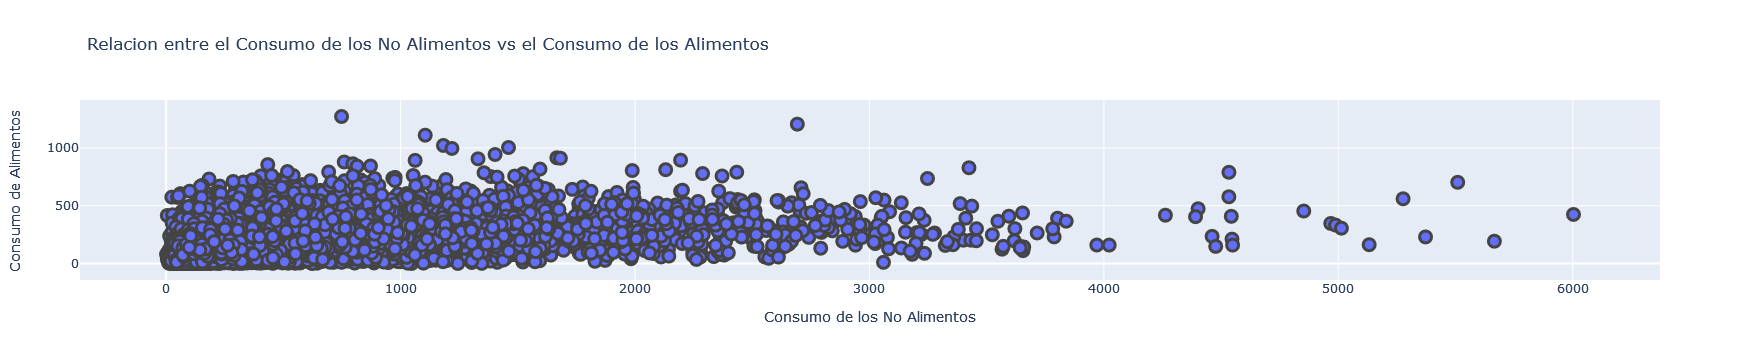

In [12]:
data = [go.Scatter(x = data_ecv["cn"],
                   y = data_ecv["ca"],
                   mode="markers",
                   marker=dict(size=12,
                               symbol="circle",
                               line={"width":3} # linea del marcador
                               ))]

layout = go.Layout(title = "Relacion entre el Consumo de los No Alimentos vs el Consumo de los Alimentos",
                   xaxis = {"title":"Consumo de los No Alimentos"},
                   yaxis = {"title":"Consumo de Alimentos"})

scatter_plot = go.Figure(data=data, layout=layout)
scatter_plot
# pyo.plot(fig, filename="Ejemplo de Scatter Plot") # Esta linea basicamente me genera un *.html que muestra que contiene el grafico de dispersion

### Creacion de un Line Plot

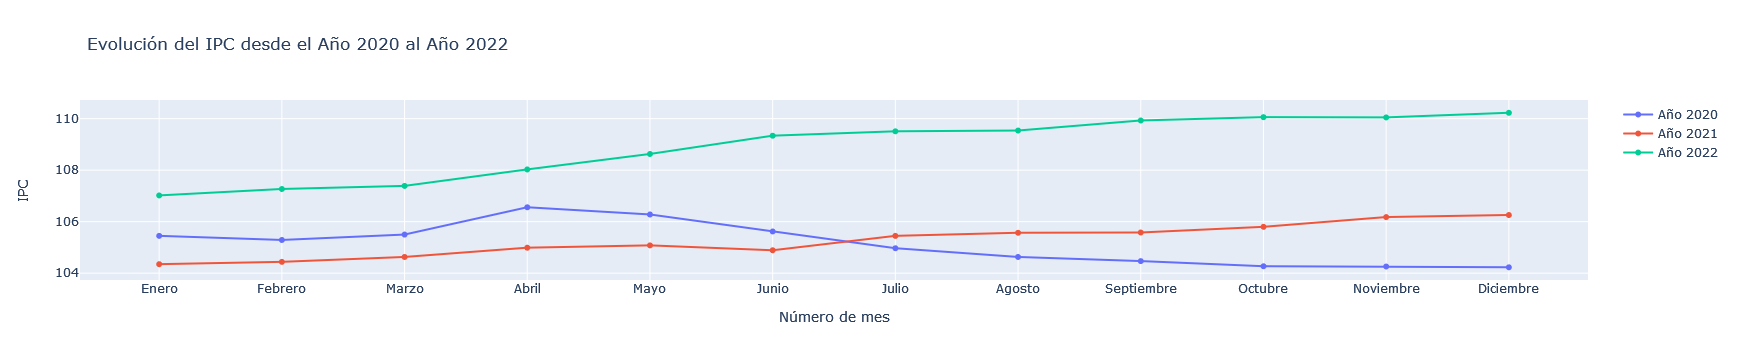

In [13]:
graf_1 = go.Scatter(x = ipc["Mes"],
                     y = ipc["2020"],
                     mode="lines+markers",
                     name="Año 2020")

graf_2 = go.Scatter(x = ipc["Mes"],
                     y = ipc["2021"],
                     mode="lines+markers",
                     name="Año 2021")

graf_3 = go.Scatter(x = ipc["Mes"],
                     y = ipc["2022"],
                     mode="lines+markers",
                     name="Año 2022")

data = [graf_1, graf_2, graf_3]

layout = go.Layout(title="Evolución del IPC desde el Año 2020 al Año 2022",
                   xaxis=dict(title="Número de mes"),
                   yaxis=dict(title="IPC"))

line_plot = go.Figure(data=data, layout=layout)
line_plot

### Grafico de Barras

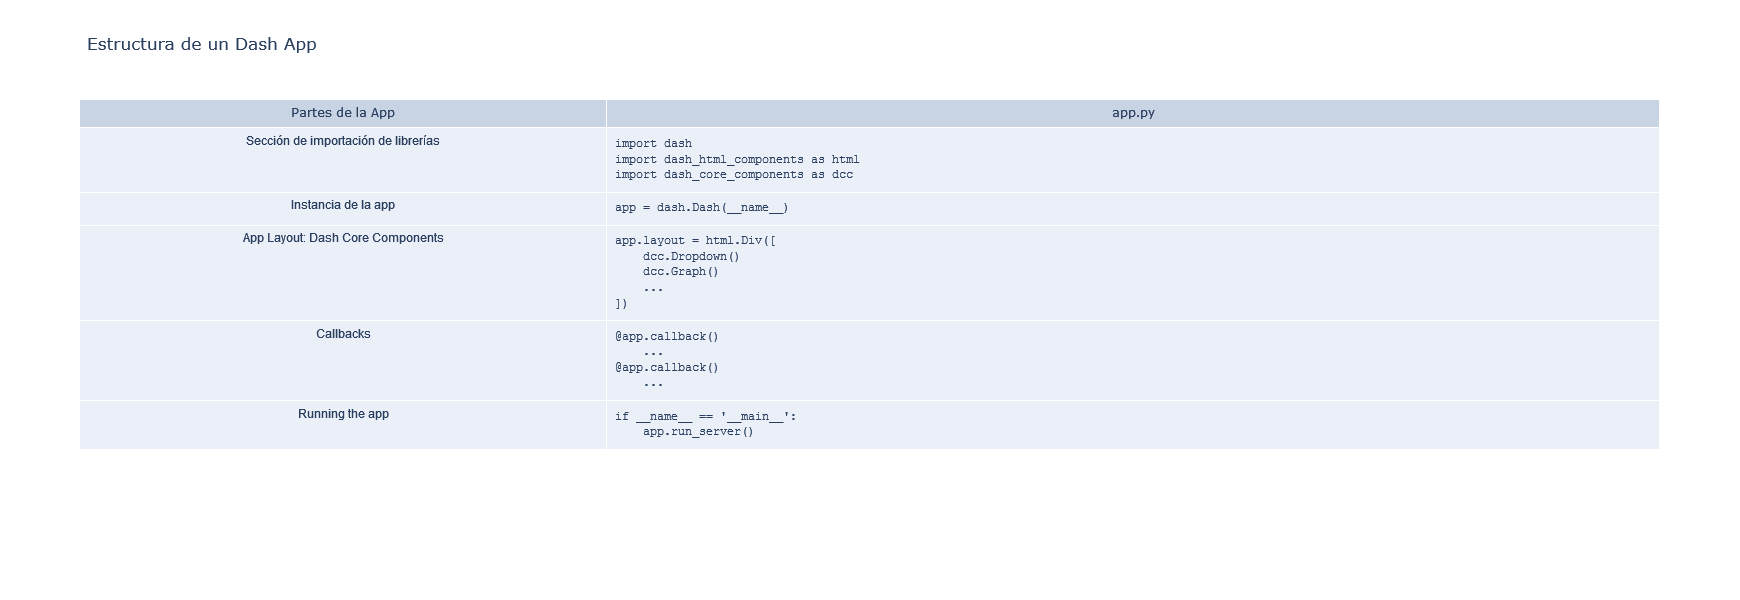

In [14]:
import plotly.graph_objects as go
app_code = [
    'import dash<br>import dash_html_components as html<br>import dash_core_components as dcc<br>',
    'app = dash.Dash(__name__)<br>',
    'app.layout = html.Div([<br>    dcc.Dropdown()<br>    dcc.Graph()<br>    ...<br>])',
    '@app.callback()<br>    ...<br>@app.callback()<br>    ...',
    "if __name__ == '__main__':<br>    app.run_server()"]

app_parts = [
    'Sección de importación de librerías', 
    'Instancia de la app',
    'App Layout: Dash Core Components',
    'Callbacks',
    'Running the app']

fig = go.Figure()
fig.add_table(header={'values': ['Partes de la App', 'app.py'], },
              cells={'values': [app_parts, app_code], 
                     'align':['center','left'],
                     'font': {'family': ['Arial', 'Courier']}},
              columnwidth=[250, 500])
fig.layout.height= 600
fig.layout.title = 'Estructura de un Dash App'

fig

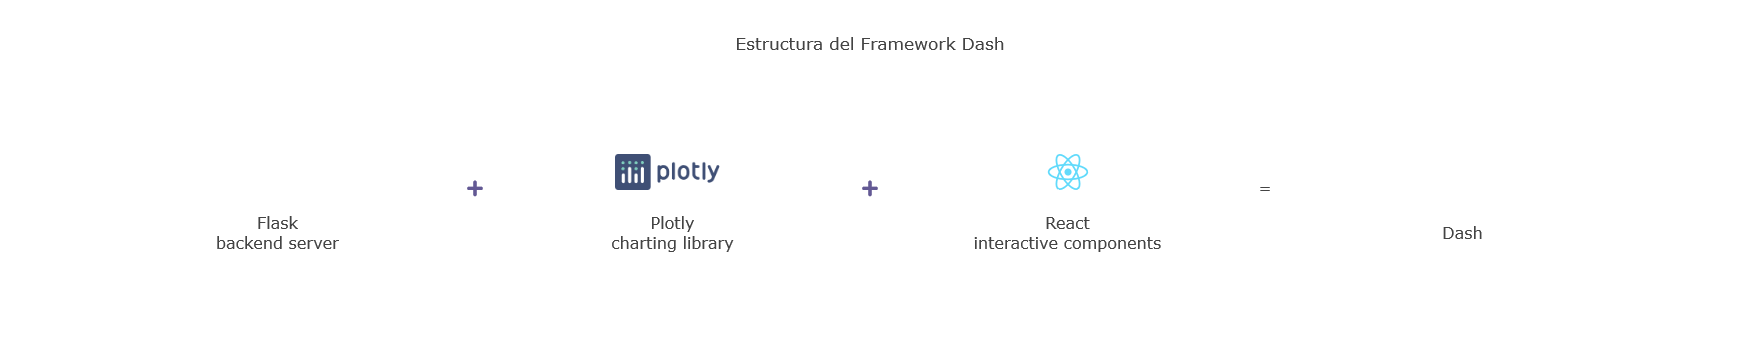

In [21]:
import plotly.graph_objects as go
source='https://raw.githubusercontent.com/cldougl/plot_images/add_r_img/vox.png'
sources = [
    'https://flask.palletsprojects.com/en/1.1.x/_images/flask-logo.png',
    'https://images.prismic.io/plotly-marketing-website/bd1f702a-b623-48ab-a459-3ee92a7499b4_logo-plotly.svg?auto=compress,format',
    'data:image/svg+xml;base64,PHN2ZyB4bWxucz0iaHR0cDovL3d3dy53My5vcmcvMjAwMC9zdmciIHZpZXdCb3g9Ii0xMS41IC0xMC4yMzE3NCAyMyAyMC40NjM0OCI+CiAgPHRpdGxlPlJlYWN0IExvZ288L3RpdGxlPgogIDxjaXJjbGUgY3g9IjAiIGN5PSIwIiByPSIyLjA1IiBmaWxsPSIjNjFkYWZiIi8+CiAgPGcgc3Ryb2tlPSIjNjFkYWZiIiBzdHJva2Utd2lkdGg9IjEiIGZpbGw9Im5vbmUiPgogICAgPGVsbGlwc2Ugcng9IjExIiByeT0iNC4yIi8+CiAgICA8ZWxsaXBzZSByeD0iMTEiIHJ5PSI0LjIiIHRyYW5zZm9ybT0icm90YXRlKDYwKSIvPgogICAgPGVsbGlwc2Ugcng9IjExIiByeT0iNC4yIiB0cmFuc2Zvcm09InJvdGF0ZSgxMjApIi8+CiAgPC9nPgo8L3N2Zz4K',
    '/Users/Elias/GoogleDrive/dash_book/dash-logo.png'

]

fig = go.Figure()

fig.add_scatter(x=[1, 2, 3, 4, 5, 6, 7],
                y=[1, 2, 1, 2, 1, 2, 1], 
                text=['Flask<br>backend server', '➕', 'Plotly<br>charting library', 
                      '➕', 'React<br>interactive components', '=', 'Dash'],
                textfont={'size': 16},
                mode='text')

for i, j in enumerate([1, 3, 5, 7]):
    fig.add_layout_image(source=sources[i], 
                         xref="paper", yref="paper",
                         x=j/8, 
                         y=.5,
                         sizex=0.2, sizey=0.2,
                         xanchor="center",
                         yanchor="bottom")

fig.layout.yaxis.range = [0, 4]
fig.layout.xaxis.range = [0, 8]

fig.layout.xaxis.showticklabels = False
fig.layout.xaxis.showgrid = False
fig.layout.xaxis.zeroline = False
fig.layout.yaxis.showticklabels = False
fig.layout.yaxis.showgrid = False
fig.layout.yaxis.zeroline = False
fig.layout.template = 'none'
fig.layout.title = 'Estructura del Framework Dash'
fig